# Assignment 2 Solution

This is my solution to [Assignment 2](https://cs533.ekstrandom.net/assignments/a2/).

In this notebook we are exploring two-variable relationships in the [HETREC 2011 Movie data](https://grouplens.org/datasets/hetrec-2011/).

## Setup

Let's start with our modules:

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [4]:
np.random.seed(20210926)

### Movie Data

We're going to need the Movie data - let's go ahead and index by movie:

In [7]:
raw_movies = pd.read_table('../data/hetrec2011-ml/movies.dat', sep='\t', na_values=['\\N'], encoding='latin1')
raw_movies = raw_movies.set_index('id')
raw_movies.head()

,title,imdbID,spanishTitle,imdbPictureURL,year,rtID,rtAllCriticsRating,rtAllCriticsNumReviews,rtAllCriticsNumFresh,rtAllCriticsNumRotten,rtAllCriticsScore,rtTopCriticsRating,rtTopCriticsNumReviews,rtTopCriticsNumFresh,rtTopCriticsNumRotten,rtTopCriticsScore,rtAudienceRating,rtAudienceNumRatings,rtAudienceScore,rtPictureURL
id,,,,,,,,,,,,,,,,,,,,
1,Toy story,114709,Toy story (juguetes),http://ia.media-imdb.com/images/M/MV5BMTMwNDU0...,1995,toy_story,9.0,73.0,73.0,0.0,100.0,8.5,17.0,17.0,0.0,100.0,3.7,102338.0,81.0,http://content7.flixster.com/movie/10/93/63/10...
2,Jumanji,113497,Jumanji,http://ia.media-imdb.com/images/M/MV5BMzM5NjE1...,1995,1068044-jumanji,5.6,28.0,13.0,15.0,46.0,5.8,5.0,2.0,3.0,40.0,3.2,44587.0,61.0,http://content8.flixster.com/movie/56/79/73/56...
3,Grumpy Old Men,107050,Dos viejos gruñones,http://ia.media-imdb.com/images/M/MV5BMTI5MTgy...,1993,grumpy_old_men,5.9,36.0,24.0,12.0,66.0,7.0,6.0,5.0,1.0,83.0,3.2,10489.0,66.0,http://content6.flixster.com/movie/25/60/25602...
4,Waiting to Exhale,114885,Esperando un respiro,http://ia.media-imdb.com/images/M/MV5BMTczMTMy...,1995,waiting_to_exhale,5.6,25.0,14.0,11.0,56.0,5.5,11.0,5.0,6.0,45.0,3.3,5666.0,79.0,http://content9.flixster.com/movie/10/94/17/10...
5,Father of the Bride Part II,113041,Vuelve el padre de la novia (Ahora también abu...,http://ia.media-imdb.com/images/M/MV5BMTg1NDc2...,1995,father_of_the_bride_part_ii,5.3,19.0,9.0,10.0,47.0,5.4,5.0,1.0,4.0,20.0,3.0,13761.0,64.0,http://content8.flixster.com/movie/25/54/25542...


How big is this frame?

In [8]:
raw_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10197 entries, 1 to 65133
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   title                   10197 non-null  object 
 1   imdbID                  10197 non-null  int64  
 2   spanishTitle            10197 non-null  object 
 3   imdbPictureURL          10016 non-null  object 
 4   year                    10197 non-null  int64  
 5   rtID                    9886 non-null   object 
 6   rtAllCriticsRating      9967 non-null   float64
 7   rtAllCriticsNumReviews  9967 non-null   float64
 8   rtAllCriticsNumFresh    9967 non-null   float64
 9   rtAllCriticsNumRotten   9967 non-null   float64
 10  rtAllCriticsScore       9967 non-null   float64
 11  rtTopCriticsRating      9967 non-null   float64
 12  rtTopCriticsNumReviews  9967 non-null   float64
 13  rtTopCriticsNumFresh    9967 non-null   float64
 14  rtTopCriticsNumRotten   9967 non-null 

20 columns and 10K movies.

Now, as noted in [Missing Data](https://cs533.ekstrandom.net/resources/tutorials/missingdata/), a lot of Rotten Tomatoes columns use zeros to record missing data.  Since a 'rating' is the average of 1-5 or 1-10 star ratings, 0 is an invalid value, so we assume those are actually missing.  Let's create a simplified movies frame that just has the fields we need, and replaces those zeros with missing values.

In [9]:
movies = raw_movies[['title', 'rtAllCriticsRating', 'rtTopCriticsRating', 'rtAudienceRating']]
movies = movies.copy()  # so changes don't change original data
movies.rename(columns={
    'rtAllCriticsRating': 'AllCritics',
    'rtTopCriticsRating': 'TopCritics',
    'rtAudienceRating': 'Audience'
}, inplace=True)
movies.head()

,title,AllCritics,TopCritics,Audience
id,,,,
1,Toy story,9.0,8.5,3.7
2,Jumanji,5.6,5.8,3.2
3,Grumpy Old Men,5.9,7.0,3.2
4,Waiting to Exhale,5.6,5.5,3.3
5,Father of the Bride Part II,5.3,5.4,3.0


And now we can clear zeros:

In [10]:
movies.loc[movies['AllCritics'] == 0, 'AllCritics'] = np.nan
movies.loc[movies['TopCritics'] == 0, 'TopCritics'] = np.nan
movies.loc[movies['Audience'] == 0, 'Audience'] = np.nan

In [11]:
movies.describe()

,AllCritics,TopCritics,Audience
count,8441.000000,4662.000000,7345.000000
mean,6.068404,5.930330,3.389258
std,1.526898,1.534093,0.454034
min,1.200000,1.600000,1.500000
25%,5.000000,4.800000,3.100000
50%,6.200000,6.100000,3.400000
75%,7.200000,7.100000,3.700000
max,9.600000,10.000000,5.000000


In [12]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10197 entries, 1 to 65133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   title       10197 non-null  object 
 1   AllCritics  8441 non-null   float64
 2   TopCritics  4662 non-null   float64
 3   Audience    7345 non-null   float64
dtypes: float64(3), object(1)
memory usage: 398.3+ KB


### Ratings

We also need the MovieLens ratings for each movie:

In [13]:
ratings = pd.read_table('../data/hetrec2011-ml/user_ratedmovies-timestamps.dat', sep='\t')
ratings.head()

,userID,movieID,rating,timestamp
0,75,3,1.0,1162160236000
1,75,32,4.5,1162160624000
2,75,110,4.0,1162161008000
3,75,160,2.0,1162160212000
4,75,163,4.0,1162160970000


In [14]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 855598 entries, 0 to 855597
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userID     855598 non-null  int64  
 1   movieID    855598 non-null  int64  
 2   rating     855598 non-null  float64
 3   timestamp  855598 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 26.1 MB


In [15]:
ratings['rating'].describe()

count    855598.000000
mean          3.437945
std           1.002561
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

856K ratings - ok!

Later on, we are going to need movie statistics. Let's compute those now:

In [16]:
movie_stats = ratings.groupby('movieID')['rating'].agg(['count', 'mean'])
movie_stats.head()

,count,mean
movieID,,
1,1263,3.735154
2,765,2.976471
3,252,2.873016
4,45,2.577778
5,225,2.753333


By way of description, let's look at the distribution of rating counts.  This will be heavily skewed, so it's going to be easeist to draw either with a log-log plot or with a *cumulative distribution chart* with a log-scaled X axis:

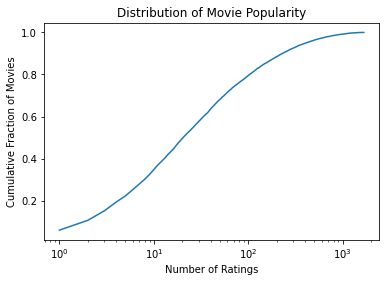

In [17]:
movie_pops = movie_stats['count'].value_counts().sort_index()
movie_cdf = movie_pops.cumsum() / movie_pops.sum()
movie_cdf.plot()
plt.xscale('log')
plt.xlabel('Number of Ratings')
plt.ylabel('Cumulative Fraction of Movies')
plt.title('Distribution of Movie Popularity')
plt.show()

### Supplemental Movie Information

We're going to need movie genres as well, so load those:

In [23]:
movie_genres = pd.read_table('../data/hetrec2011-ml/movie_genres.dat', sep='\t')
movie_genres.head()

,movieID,genre
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy


In [24]:
movie_genres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20809 entries, 0 to 20808
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieID  20809 non-null  int64 
 1   genre    20809 non-null  object
dtypes: int64(1), object(1)
memory usage: 325.3+ KB


21K movie-genre records. By way of description, let's see how common different genres are:

<AxesSubplot:xlabel='count', ylabel='genre'>

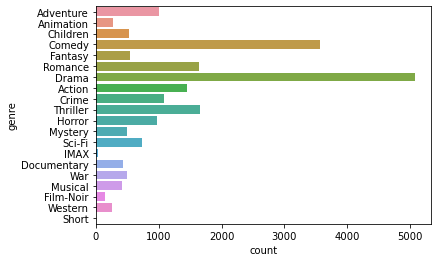

In [25]:
sns.countplot(y=movie_genres['genre'])

## Comparing Ratings

Now we're going to compare ratings:

* All Critics and Top Critics
* RottenTomatoes audience and MovieLens audience

For this, we're going to need to augment our movies with an additional column - the mean rating from MovieLens.  Since we already computed MovieLens stats, we can do this with a join (left join, to keep ML as it is):

In [26]:
movies = movies.join(movie_stats['mean'].to_frame('MovieLens'), how='left')
movies.head()

,title,AllCritics,TopCritics,Audience,MovieLens
id,,,,,
1,Toy story,9.0,8.5,3.7,3.735154
2,Jumanji,5.6,5.8,3.2,2.976471
3,Grumpy Old Men,5.9,7.0,3.2,2.873016
4,Waiting to Exhale,5.6,5.5,3.3,2.577778
5,Father of the Bride Part II,5.3,5.4,3.0,2.753333


### Describing Distributions

Our task is now to describre the distributions of the four movie rating columns.  I'm going to do this quickly with one set of columns and plots.  First the numeric description:

In [27]:
movies.drop(columns=['title']).describe()

,AllCritics,TopCritics,Audience,MovieLens
count,8441.000000,4662.000000,7345.000000,10109.000000
mean,6.068404,5.930330,3.389258,3.213406
std,1.526898,1.534093,0.454034,0.640538
min,1.200000,1.600000,1.500000,0.500000
25%,5.000000,4.800000,3.100000,2.851293
50%,6.200000,6.100000,3.400000,3.312415
75%,7.200000,7.100000,3.700000,3.681452
max,9.600000,10.000000,5.000000,5.000000


All and top critics have comparable means, all is slightly higher.  All four ratings have slight left skew (median is higher than mean).

Let's visualize them.

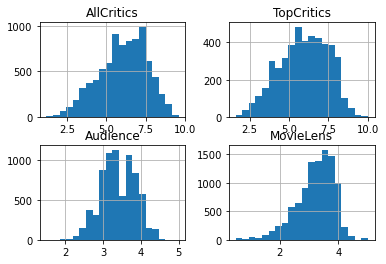

In [28]:
movies.hist(bins=20)
plt.show()

Let skew is showing up here too!  To really highlight what's going on, we would carefully align them so that Critics and Audience are in columns, and X axes are matched so we can directly compare All/Top and Audience/ML.  I'm not going to do that right now.

### Critic Rating Differences

We now want to look at the *differnce* between top and all critics. We're going to do this with All - Top:

In [29]:
movies['CritDiff'] = movies['AllCritics'] - movies['TopCritics']
movies['CritDiff'].describe()

count    4662.000000
mean        0.094123
std         0.549673
min        -2.200000
25%        -0.200000
50%         0.100000
75%         0.400000
max         3.200000
Name: CritDiff, dtype: float64

A positive mean (and median) indicates that, on average, top critics probably underestimate all-critic ratings. We'll test that formally with the T-test, of course.

But let's plot this distribution:

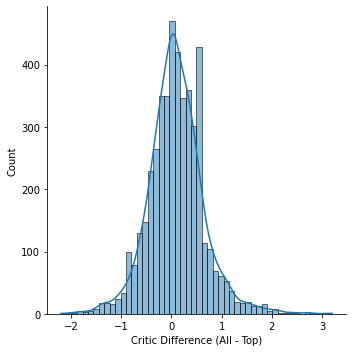

In [36]:
sns.displot(x=movies['CritDiff'], kde=True, bins=50)
plt.xlabel('Critic Difference (All - Top)')
plt.show()

We've got an extra spike at approximately 0.5 stars.  Otherwise it's a pretty symmetric difference, centered close to zero (but as the numeric stats indicate, the center point is just above zero), and approximately normal..

### Testing Differences

Now we're going to use the **paired T-test** to test the difference in critic ratings: do top-critic ratings statistically significantly differ from all-critic ratings?

In [37]:
sps.ttest_rel(movies['AllCritics'], movies['TopCritics'], nan_policy='omit')

Ttest_relResult(statistic=11.691646881769836, pvalue=3.8130588929989856e-31)

That is an extremely small $p$-value.  We're going to go with 'significant'.

Now compare MovieLens to the RT audience:

In [38]:
sps.ttest_rel(movies['Audience'], movies['MovieLens'], nan_policy='omit')

Ttest_relResult(statistic=27.766895811705442, pvalue=2.038842597476695e-161)

Even smaller.

This is **not surprising**, because we very large sample sizes.

## Confidence Intervals

Now we're going to move to the confidence interval portion of the assignment - look at average ratings between genres.

Let's merge genres with movies:

In [39]:
genre_movies = movie_genres.join(movies, on='movieID')
genre_movies.head()

,movieID,genre,title,AllCritics,TopCritics,Audience,MovieLens,CritDiff
0,1,Adventure,Toy story,9.0,8.5,3.7,3.735154,0.5
1,1,Animation,Toy story,9.0,8.5,3.7,3.735154,0.5
2,1,Children,Toy story,9.0,8.5,3.7,3.735154,0.5
3,1,Comedy,Toy story,9.0,8.5,3.7,3.735154,0.5
4,1,Fantasy,Toy story,9.0,8.5,3.7,3.735154,0.5


Now we can group by genre to compute statistics of the all-critics score.  The `sem` aggregate computes the *standard error of the mean*, which we'll use for the confidence intervals:

In [40]:
genre_scores = genre_movies.groupby('genre')['AllCritics'].agg(['mean', 'count', 'std', 'sem'])
genre_scores.head()

,mean,count,std,sem
genre,,,,
Action,5.574497,1192,1.560583,0.045201
Adventure,5.952876,817,1.519157,0.053149
Animation,6.343404,235,1.393417,0.090897
Children,5.779864,442,1.532010,0.072870
Comedy,5.732409,3030,1.546115,0.028088


Now we need to do two more things:

1. Compute the 95% CS (± 1.96 SEM)
2. Sort by decreasing mean

In [41]:
genre_scores['ci_lo'] = genre_scores['mean'] - 1.96 * genre_scores['sem']
genre_scores['ci_hi'] = genre_scores['mean'] + 1.96 * genre_scores['sem']
genre_scores.sort_values('mean', ascending=False, inplace=True)
genre_scores

,mean,count,std,sem,ci_lo,ci_hi
genre,,,,,,
Film-Noir,7.253543,127,1.273527,0.113007,7.032049,7.475038
Documentary,7.129641,334,0.979147,0.053577,7.024631,7.234651
IMAX,6.950000,16,0.747440,0.186860,6.583754,7.316246
War,6.753351,388,1.354775,0.068778,6.618545,6.888156
Western,6.613472,193,1.394007,0.100343,6.416800,6.810143
Musical,6.483573,347,1.319328,0.070825,6.344756,6.622391
Drama,6.462657,4306,1.337138,0.020377,6.422718,6.502596
Animation,6.343404,235,1.393417,0.090897,6.165247,6.521561
Mystery,6.228571,434,1.488513,0.071451,6.088528,6.368615


The top two scores are *Film-Noir* and *Documentary*, with mean critic scores of 7.25 and 7.13, respectively. Their CIs have **substantial overlap**, so we can't conclude that this score difference reflects a difference in general opinion.

The top and bottom genres (*Film-Noir* and *Horror*, however, have a large gap between confidence intervals.  Likely a real difference - the data are consistent with the idea that critics view film-noir movies more highly than horror films.

Now let's bootstrap it!  We'll write a bootstrap CI function, that also returns the mean for convenience:

In [42]:
def boot_mean(scores, nboot=10000):
    strim = scores.dropna()
    n = len(strim)
    if n == 0:
        return None
    mean = np.mean(strim)
    boot_means = [np.mean(np.random.choice(strim, n, replace=True)) for i in range(nboot)]
    ci_lo, ci_hi = np.quantile(boot_means, [0.025, 0.975])
    return pd.Series({
        'mean': mean,
        'count': n,
        'ci_lo': ci_lo,
        'ci_high': ci_hi
    })

In [43]:
genre_boot_stats = genre_movies.groupby('genre')['AllCritics'].apply(boot_mean)
genre_boot_stats = genre_boot_stats.unstack()
genre_boot_stats.sort_values('mean', ascending=False)

,mean,count,ci_lo,ci_high
genre,,,,
Film-Noir,7.253543,127.0,7.029134,7.468504
Documentary,7.129641,334.0,7.025142,7.234439
IMAX,6.950000,16.0,6.600000,7.306250
War,6.753351,388.0,6.618035,6.886598
Western,6.613472,193.0,6.416049,6.808808
Musical,6.483573,347.0,6.343213,6.617579
Drama,6.462657,4306.0,6.422689,6.502531
Animation,6.343404,235.0,6.165532,6.518309
Mystery,6.228571,434.0,6.086861,6.367972


The menas are the same, obviously.  These CIs are also quite comparable to the standard error ones, and lead to the same conclusions (no significant difference between top two genres, wide difference between top and bottom).

I noted in the instructions that these groups are *not independent*.  This is because a movie can appear in multiple genres.  This means that the different distributions **cannot** be treated as independent samples.  We can compute confidence intervals, and make some inferences, but we need to be conservative.  Wide gaps are wide enough that it's unlikely that the non-independence is a problem.  However, if we were to run paired T-tests, or an ANOVA, it would be invalid, because they assume an independence between samples that is clearly violated.  A bootstrap test won't help us either.  We can try to estimate the parameters, but clear hypothesis-testing outcomes require great care.

## Popularity and Bootstraps

The last part of the assignment is to look at the difference in popularity and mean all critic ratings between two genres: action and documentary. Note the independence assumption in the previous paragraph - there are some validity problems here. I'm going to revisit this if I use this assignment in the future.

However, let's see if we have any movies in both genres:

In [46]:
acts = genre_movies[genre_movies['genre'] == 'Action']
docs = genre_movies[genre_movies['genre'] == 'Documentary']

In [47]:
np.intersect1d(acts['movieID'], docs['movieID'])

array([32593], dtype=int64)

There is one movie categorized as both movie types.  So the individual samples are pretty independent.

I'm curious - what is that movie?

In [48]:
movies.loc[np.intersect1d(acts['movieID'], docs['movieID'])]

,title,AllCritics,TopCritics,Audience,MovieLens,CritDiff
id,,,,,,
32593,Dust to Glory,6.2,6.0,4.2,3.4,0.2


### Popularity

First thing we need is the popularity info.  We can get it from our movie stats:

In [49]:
acts = acts.join(movie_stats['count'].to_frame('MLPop'), on='movieID', how='left')
docs = docs.join(movie_stats['count'].to_frame('MLPop'), on='movieID', how='left')

Now let's look at the medians:

In [50]:
acts['MLPop'].describe()

count    1442.000000
mean      167.540222
std       261.808078
min         1.000000
25%        12.250000
50%        56.000000
75%       208.000000
max      1670.000000
Name: MLPop, dtype: float64

In [51]:
docs['MLPop'].describe()

count    418.000000
mean      31.095694
std       72.722530
min        1.000000
25%        4.000000
50%       11.500000
75%       28.000000
max      823.000000
Name: MLPop, dtype: float64

Action movies have a median rating count of 56, and documentaries 11.5.

Let's bootstrap CIs for these.  We're going to reuse my independent bootstrap function from Penguin Inference, except we're going to replace the `mean` statistic with `median`:

In [52]:
def boot_medians(s1, s2, nboot=10000):
    ## we will ignore NAs here
    obs1 = s1.dropna()
    obs2 = s2.dropna()
    n1 = len(obs1)
    n2 = len(obs2)
    
    ## pool the observations together
    pool = pd.concat([obs1, obs2])
    ## grab the observed difference in medians
    md = np.median(obs1) - np.median(obs2)
    
    ## compute our bootstrap samples of the median under H0
    b1 = np.array([np.median(np.random.choice(pool, size=n1)) for i in range(nboot)])
    b2 = np.array([np.median(np.random.choice(pool, size=n2)) for i in range(nboot)])
    
    ## the P-value is the probability that we observe a difference as large
    ## as we did in the raw data, if the null hypothesis were true
    return md, np.mean(np.abs(b1 - b2) >= np.abs(md))

The **last** `mean` stays a mean, because it is not our statistic: it is computing our *p*-value as the proportion of bootstrap samples with a statistic as extreme as the observed statistic.

Now let's use it:

In [53]:
boot_medians(acts['MLPop'], docs['MLPop'])

(44.5, 0.0)

The difference in medians **is statistically significant**.

### Mean Rating

Now let's test the All Critics rating:

In [54]:
sps.ttest_ind(acts['AllCritics'], docs['AllCritics'], nan_policy='omit')

Ttest_indResult(statistic=-17.28144197127851, pvalue=3.024636237600687e-61)

That is a very low $p$-value - clear statistical significance.

Want to see a cool trick? We can *parameterize* our bootstrap function over the statistic - functions are objects, and we can pass them as parameters and call them:

In [55]:
def boot_ind(s1, s2, stat=np.mean, nboot=10000):
    ## we will ignore NAs here
    obs1 = s1.dropna()
    obs2 = s2.dropna()
    n1 = len(obs1)
    n2 = len(obs2)
    
    ## pool the observations together
    pool = pd.concat([obs1, obs2])
    ## grab the observed difference in statistics
    md = stat(obs1) - stat(obs2)
    
    ## compute our bootstrap samples of the median under H0
    b1 = np.array([stat(np.random.choice(pool, size=n1)) for i in range(nboot)])
    b2 = np.array([stat(np.random.choice(pool, size=n2)) for i in range(nboot)])
    
    ## the P-value is the probability that we observe a difference as large
    ## as we did in the raw data, if the null hypothesis were true
    return md, np.mean(np.abs(b1 - b2) >= np.abs(md))

Now use it - we left the default as `mean`:

In [56]:
boot_ind(acts['AllCritics'], docs['AllCritics'])

(-1.5551440742675675, 0.0)

Statistically significant difference.  The statistic is different, because we are not computing a *t*-statistic in our bootstrapped version.

But we can reuse this version of the bootstrap function for the medians too:

In [57]:
boot_ind(acts['MLPop'], docs['MLPop'], stat=np.median)

(44.5, 0.0)

Neat, huh?